In [100]:
# bibliotecas básicas
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch import optim
from torch import tensor
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

%matplotlib inline

# Preparando a base de Dados

In [101]:
df = pd.read_csv('./rice.csv', header=None)

y = df.iloc[0:, 7].values
y = np.where(y == 'Cammeo', -1, 1) # realizado o tratamento do classe categorica (string -> int)


X = df.iloc[0:, [2,3,4,6]].values # atributos utilizados

# Divisão do base em treino e teste

In [102]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.20, random_state=102) # 80% treinamento 20% teste

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Modelo

In [103]:
LEARNING_RATE = 0.001

in_features = 4
hidden_dim = 5
hidden_dim2 = 5
out_features = 1


modelRNA = nn.Sequential(
    nn.Linear(in_features, hidden_dim),
    nn.LeakyReLU(),
    nn.Linear(hidden_dim, hidden_dim2),
    nn.LeakyReLU(),
    nn.Linear(hidden_dim2, out_features)
)

loss_function = nn.MSELoss()
optimizer = optim.SGD(modelRNA.parameters(), 
                      lr=LEARNING_RATE)

# Treinando o modelo

In [104]:
Loss = []
BATCH_SIZE = 2
EPOCHS = 1000

# determine the device we will be using for training
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("[INFO] Treinamento será realizado com {}...".format(DEVICE))

for epoch in range(EPOCHS):
  
  indices = np.arange(X_train.shape[0])
  np.random.shuffle(indices)
  X_train = X_train[indices]
  y_train = y_train[indices]

  custo = 0

  for i in range(0, len(X_train), BATCH_SIZE):
    Xbatch = X_train[i:i+BATCH_SIZE]
    ybatch = y_train[i:i+BATCH_SIZE]

    y_pred = modelRNA(Xbatch)

    loss = loss_function(y_pred, ybatch)
    custo += loss.detach()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if epoch == 0:
    print("Época   | Loss")
    print(f"{epoch:^4}    | {loss:.3}")
  Loss.append(custo)
print(f"{epoch:^4}    | {loss:.3}")

[INFO] Treinamento será realizado com cpu...
Época   | Loss
 0      | 0.792
999     | 0.307


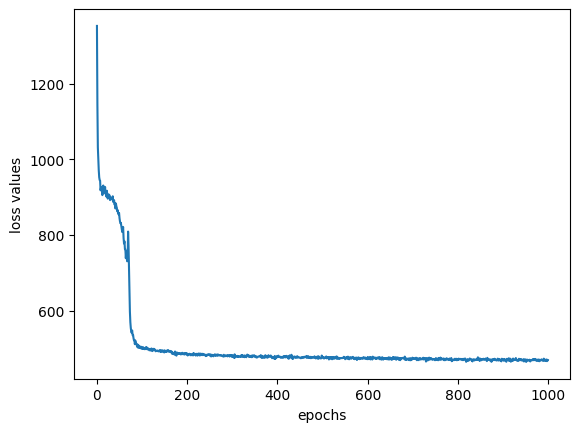

In [105]:
plt.plot(Loss)
plt.xlabel("epochs")
plt.ylabel("loss values")
plt.show()

# Precisão do modelo com a base de teste

In [106]:
y_pred = modelRNA(X_test)
accuracy = (torch.round(y_pred) - y_test == 0).float().mean()
print(f"Precisão depois treinamento {accuracy*100:.2f}%")

Precisão depois treinamento 69.16%
